# Cartpole-v0 
# Shahid Gulzar Padder
# XPXSKK

0
1
2
3
4
5
6
7
8
9


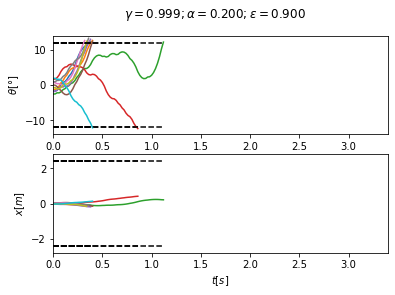

In [6]:
"""Sarsa algorithm implementation."""

import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def sarsa_control(env, max_num_episodes, discount=1.0, eps=0.001, alpha=0.05):
    """Sarsa control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = x = thetas = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = env.reset()
        x = [state[0]]
        thetas = [state[2]*360/(2*np.pi)]
        state = build_state(state)
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)
        probs = policy(state)
        action = rnd.choice(possible_actions, p=probs)

        for t in itertools.count():
            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            x.append(next_state[0])
            thetas.append(next_state[2]*360/(2*np.pi))
            next_state = build_state(next_state)

            # predict next action
            probs = policy(next_state)
            next_action = rnd.choice(possible_actions, p=probs)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Sarsa update rule
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][next_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state, action = next_state, next_action

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes, x, thetas

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.9
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = ALPHA_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    # array_eps_to_conv = []
    # if (mode == EPS_ANALYSIS):
    #     eval_array = [0.001,0.003,0.006,0.01,0.013]
    # elif (mode == ALPHA_ANALYSIS):
    #     eval_array = [0.1,0.2,0.3,0.5,0.7]
    # else:
    #     eval_array = [0.999,0.8,0.7,0.6,0.5]

    x_array = []
    thetas_array = []
    for t in range(NUM_ITERATIONS):
        print(t)

        has_converged, episodes_to_converge, x, thetas = \
            sarsa_control(env, max_num_episodes, discount, eps, alpha)

        x_array.append(x)
        thetas_array.append(thetas)

    fig = plt.figure()
    title = r'$\gamma = {:.3f}; \alpha = {:.3f}; \epsilon = {:.3f}$'\
                .format(discount, alpha, eps)
    plt.suptitle(title)
    name = 'sarsa_variable_plot.png'

    ax = fig.add_subplot(211)
    ylabel = r'$\theta [°]$'
    xlabel = r'$t [s]$'
    ax.set_ylabel(ylabel)
    for i in range(len(thetas_array)):
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), thetas_array[i])
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), np.tile(12,len(thetas_array[i])), linestyle='--', color='black')
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), np.tile(-12,len(thetas_array[i])), linestyle='--', color='black')
    ax.set_ylim((-14,14))
    ax.set_xlim((0,3.4))

    ax = fig.add_subplot(212)
    ylabel = r'$x [m]$'
    xlabel = r'$t [s]$'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    for i in range(len(x_array)):
        ax.plot(np.arange(len(x_array[i])).dot(0.02), x_array[i])
        ax.plot(np.arange(len(x_array[i])).dot(0.02), np.tile(2.4,len(x_array[i])), linestyle='--', color='black')
        ax.plot(np.arange(len(x_array[i])).dot(0.02), np.tile(-2.4,len(x_array[i])), linestyle='--', color='black')
    ax.set_ylim((-2.8,2.8))
    ax.set_xlim((0,3.4))


    plt.savefig(name)
    #plt.show()

0
1
2
3
4
5
6
7
8
9


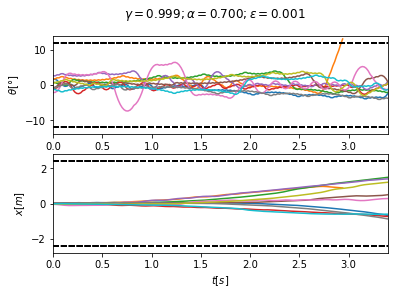

In [7]:
"""Sarsa algorithm implementation."""

import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def sarsa_control(env, max_num_episodes, discount=1.0, eps=0.001, alpha=0.05):
    """Sarsa control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = x = thetas = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = env.reset()
        x = [state[0]]
        thetas = [state[2]*360/(2*np.pi)]
        state = build_state(state)
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)
        probs = policy(state)
        action = rnd.choice(possible_actions, p=probs)

        for t in itertools.count():
            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            x.append(next_state[0])
            thetas.append(next_state[2]*360/(2*np.pi))
            next_state = build_state(next_state)

            # predict next action
            probs = policy(next_state)
            next_action = rnd.choice(possible_actions, p=probs)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Sarsa update rule
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][next_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state, action = next_state, next_action

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes, x, thetas

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.999
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.7

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = EPS_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    # array_eps_to_conv = []
    # if (mode == EPS_ANALYSIS):
    #     eval_array = [0.001,0.003,0.006,0.01,0.013]
    # elif (mode == ALPHA_ANALYSIS):
    #     eval_array = [0.1,0.2,0.3,0.5,0.7]
    # else:
    #     eval_array = [0.999,0.8,0.7,0.6,0.5]

    x_array = []
    thetas_array = []
    for t in range(NUM_ITERATIONS):
        print(t)

        has_converged, episodes_to_converge, x, thetas = \
            sarsa_control(env, max_num_episodes, discount, eps, alpha)

        x_array.append(x)
        thetas_array.append(thetas)

    fig = plt.figure()
    title = r'$\gamma = {:.3f}; \alpha = {:.3f}; \epsilon = {:.3f}$'\
                .format(discount, alpha, eps)
    plt.suptitle(title)
    name = 'sarsa_variable_plot1.png'

    ax = fig.add_subplot(211)
    ylabel = r'$\theta [°]$'
    xlabel = r'$t [s]$'
    ax.set_ylabel(ylabel)
    for i in range(len(thetas_array)):
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), thetas_array[i])
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), np.tile(12,len(thetas_array[i])), linestyle='--', color='black')
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), np.tile(-12,len(thetas_array[i])), linestyle='--', color='black')
    ax.set_ylim((-14,14))
    ax.set_xlim((0,3.4))

    ax = fig.add_subplot(212)
    ylabel = r'$x [m]$'
    xlabel = r'$t [s]$'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    for i in range(len(x_array)):
        ax.plot(np.arange(len(x_array[i])).dot(0.02), x_array[i])
        ax.plot(np.arange(len(x_array[i])).dot(0.02), np.tile(2.4,len(x_array[i])), linestyle='--', color='black')
        ax.plot(np.arange(len(x_array[i])).dot(0.02), np.tile(-2.4,len(x_array[i])), linestyle='--', color='black')
    ax.set_ylim((-2.8,2.8))
    ax.set_xlim((0,3.4))


    plt.savefig(name)
    #plt.show()

0
1
2
3
4
5
6
7
8
9


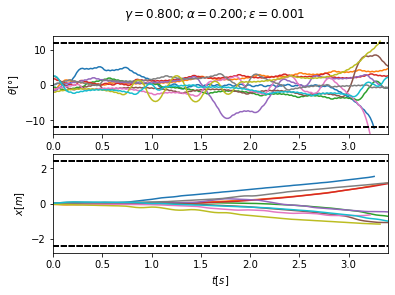

In [8]:
"""Sarsa algorithm implementation."""

import pandas
import numpy as np
import numpy.random as rnd
import gym
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt

def make_eps_greedy_policy(Q, eps, n):
    """Define a policy.
    Parameters
    ----------
    Q : array_like (n_states x n_actions)
        Action-values.
    eps : float
        Eps-greedy factor.
    n : integer
        Number of actions.
    Returns
    -------
    policy : function
        Function that returns actions given an input state (the present state).
    """
    def policy(state):
        """Define a set of actions.
        Parameters
        ----------
        state : tuple
            Present state on which depends our next action.
        Retuns
        ------
        A : array
            Probabilities for actions in the set of possible actions to be taken.
        """
        A = np.ones(n, dtype=float) * eps/n
        best = np.argmax(Q[state])
        A[best] += 1 - eps
        return A
    return policy

def sarsa_control(env, max_num_episodes, discount=1.0, eps=0.99, alpha=0.7):
    """Sarsa control.
    Parameters
    ----------
    env : OpenAI gym environment
        Environment which will be used in the simulation (CartPole-v0).
    max_num_episodes : int
        Max number of episodes to converge.
    discount : float
        Discount factor.
    eps : float
        Exploration rate (since we are using an epsilon-greedy policy).
    eps_decay : float
        Exploration rate decay over episodes.
    eps_min : float
        Min exploration rate reachable.
    Returns
    -------
    converged : bool
        True if the algorithm converged, False otherwise.
    num_episodes : int
        Number of episodes to converge.
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    possible_actions = np.arange(env.action_space.n)
    converged = False
    returns = x = thetas = []

    for num_episodes in range(max_num_episodes):
        totalreward = 0     # total reward in this episodes (+1 each step)
        state = env.reset()
        x = [state[0]]
        thetas = [state[2]*360/(2*np.pi)]
        state = build_state(state)
        policy = make_eps_greedy_policy(Q, eps, env.action_space.n)
        probs = policy(state)
        action = rnd.choice(possible_actions, p=probs)

        for t in itertools.count():
            # take the current action and observe the reward
            next_state, reward, done, _ = env.step(action)
            x.append(next_state[0])
            thetas.append(next_state[2]*360/(2*np.pi))
            next_state = build_state(next_state)

            # predict next action
            probs = policy(next_state)
            next_action = rnd.choice(possible_actions, p=probs)

            # if the cartpole system fell down during this episode
            if (done):
                # high penalization helps the convergence
                Q[state][action] += -200
                totalreward += reward
                returns.append(totalreward)
                break

            # update Q-values using Sarsa update rule
            Q[state][action] = Q[state][action] + alpha*(reward + discount*Q[next_state][next_action] - Q[state][action])

            # append this step's reward
            totalreward += reward

            state, action = next_state, next_action

        # we are not decaying in the sensibility analysis
        #if i%100 == 0:
        #    eps *= eps_decay
        #    if (eps < eps_min):
        #        eps = eps_min

        # winning condition: last 100 episodes have a mean of WINNING_MEAN total reward
        mean = np.mean(returns[-100:])
        if mean >= WINNING_MEAN:
            converged = True
            break

    return converged, num_episodes, x, thetas

def build_state(state):
    """Discretize the state returned by the environment.
    Parameters
    ----------
    state : tuple
        State returned by OpenAI gym environment.
    Returns
    -------
    _ : tuple
        The correspondent discrete state.
    """
    return (np.digitize([state[0]], cart_position_bins)[0],
            np.digitize([state[1]], cart_velocity_bins)[0],
            np.digitize([state[2]], pole_angle_bins)[0],
            np.digitize([state[3]], angle_rate_bins)[0])

if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    max_num_episodes = 6000
    discount = 0.8
    eps = 0.001
    #eps_decay = 0.0
    #eps_min = 0.01
    alpha = 0.2

    NUM_ITERATIONS = 10
    WINNING_MEAN = 170
    EPS_ANALYSIS = 0
    ALPHA_ANALYSIS = 1
    DISCOUNT_ANALYSIS = 2
    mode = DISCOUNT_ANALYSIS

    # number of discrete states
    n_bins = 8
    n_bins_angle = 10

    # discrete states for each variable
    cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
    cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
    pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
    angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

    # array_eps_to_conv = []
    # if (mode == EPS_ANALYSIS):
    #     eval_array = [0.001,0.003,0.006,0.01,0.013]
    # elif (mode == ALPHA_ANALYSIS):
    #     eval_array = [0.1,0.2,0.3,0.5,0.7]
    # else:
    #     eval_array = [0.999,0.8,0.7,0.6,0.5]

    x_array = []
    thetas_array = []
    for t in range(NUM_ITERATIONS):
        print(t)

        has_converged, episodes_to_converge, x, thetas = \
            sarsa_control(env, max_num_episodes, discount, eps, alpha)

        x_array.append(x)
        thetas_array.append(thetas)

    fig = plt.figure()
    title = r'$\gamma = {:.3f}; \alpha = {:.3f}; \epsilon = {:.3f}$'\
                .format(discount, alpha, eps)
    plt.suptitle(title)
    name = 'sarsa_variable_plot2.png'

    ax = fig.add_subplot(211)
    ylabel = r'$\theta [°]$'
    xlabel = r'$t [s]$'
    ax.set_ylabel(ylabel)
    for i in range(len(thetas_array)):
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), thetas_array[i])
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), np.tile(12,len(thetas_array[i])), linestyle='--', color='black')
        ax.plot(np.arange(len(thetas_array[i])).dot(0.02), np.tile(-12,len(thetas_array[i])), linestyle='--', color='black')
    ax.set_ylim((-14,14))
    ax.set_xlim((0,3.4))

    ax = fig.add_subplot(212)
    ylabel = r'$x [m]$'
    xlabel = r'$t [s]$'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    for i in range(len(x_array)):
        ax.plot(np.arange(len(x_array[i])).dot(0.02), x_array[i])
        ax.plot(np.arange(len(x_array[i])).dot(0.02), np.tile(2.4,len(x_array[i])), linestyle='--', color='black')
        ax.plot(np.arange(len(x_array[i])).dot(0.02), np.tile(-2.4,len(x_array[i])), linestyle='--', color='black')
    ax.set_ylim((-2.8,2.8))
    ax.set_xlim((0,3.4))


    plt.savefig(name)
    #plt.show()